## _Building Graphs: Truth of Input Edges_

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
sys.path.append('..')

In [6]:
from src import draw_event
from src import compose_event

### _(+) - Input Data_

In [9]:
# mu- data (old)
# input_dir = './data_sets/pandaml/data_3.0_7.0_GeV/'

# mu+mu- data (current)
input_dir = '../data_sets/pandaml/data_0.1_1.5_GeV/'

# pbarp data (coming)
# input_dir = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [10]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [11]:
# file_prefixes[:10]

In [12]:
event_id = 1
event_prefix = file_prefixes[event_id]

In [13]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000001 memory usage 0.03 MB


In [14]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-12.2456,12.120,35.0,9,0,12
1,2,-13.1203,12.625,35.0,9,1,117
2,3,-13.9950,13.130,35.0,9,2,228
3,4,-13.9950,14.140,35.0,9,3,344
4,5,-14.8697,14.645,35.0,9,4,467


In [15]:
hits.layer_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32)

In [16]:
tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.262386,6000300.0,6.00030,9,0,12,0,0
1,2,0.052152,13722100.0,13.72210,9,1,117,0,0
2,3,0.374347,4073350.0,4.07335,9,2,228,0,0
3,4,0.265922,6590940.0,6.59094,9,3,344,0,0
4,5,0.085074,11615800.0,11.61580,9,4,467,0,0


In [17]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,-0.134669,0.028540,-0.091022,1,25,13,0
1,2,0.0,0.0,0.0,-0.550762,-0.441498,0.780609,1,24,13,0
2,3,0.0,0.0,0.0,-0.072724,0.023378,0.175138,1,30,13,0
3,4,0.0,0.0,0.0,0.936311,-0.311491,-1.019850,1,24,13,0
4,5,0.0,0.0,0.0,-1.049040,-0.440627,0.471787,1,23,13,0


In [18]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,-12.4533,11.9370,18.0376,-0.208362,0.236490,0.330727,1.0,10
1,2,-13.0823,12.6579,19.0411,-0.206470,0.238251,0.330621,1.0,10
2,3,-13.7024,13.3791,20.0387,-0.204324,0.239940,0.330703,1.0,10
3,4,-14.1996,13.9682,20.8477,-0.202521,0.241390,0.330725,1.0,10
4,5,-14.8052,14.6980,21.8424,-0.200172,0.243415,0.330639,1.0,10


### _(+) - Build Event_

- functions from _event_utils.py_

FileNotFoundError: [Errno 2] No such file or directory: 'src/stt.csv'

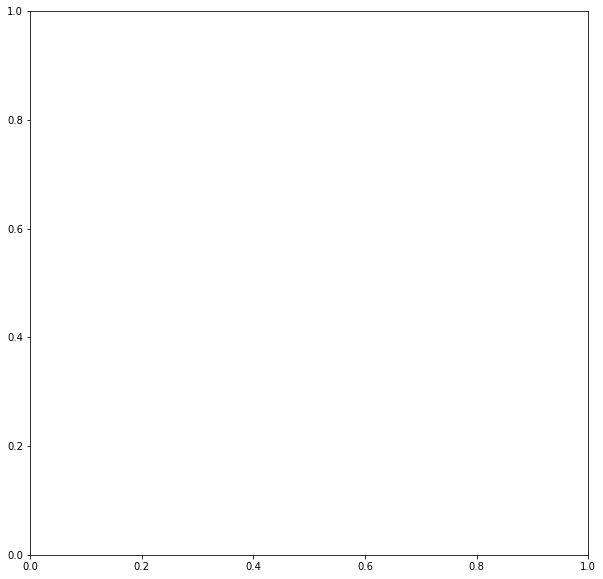

In [19]:
event = compose_event(event_prefix,skewed=False)
draw_event(event,figsize=(10, 10));

In [ ]:
event.head()

In [ ]:
event.layer.unique()

## _Build Graphs_

### _(A) - True Edges (Layerwise)_

In [20]:
from LightningModules.Processing.utils.event_utils import get_layerwise_edges

In [ ]:
# get true edges
true_edges, hits = get_layerwise_edges(event)

In [ ]:
hits.head()

### _(B) - Input Edges (Layerwise)_

In [ ]:
from LightningModules.Processing.utils.event_utils import get_input_edges

In [ ]:
# get input Edges
input_edges = get_input_edges(hits, filtering=True)

In [ ]:
# input_edges ~ edge_index
edge_index = input_edges

In [ ]:
input_edges.shape

In [ ]:
input_edges[0][:10]

In [ ]:
input_edges[1][:10]

### _(+) - Plotting Input Edges_

In [ ]:
# plotting input_edges
plt.close('all')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

p_ids = np.unique(event.particle_id.values)
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one may look for +ve/-ve polarity
    
# detector layout
plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# particle tracks
sel_pids, sel_pids_fr = np.unique(hits.particle_id, return_counts=True)

for pid in sel_pids:
    idx = hits.particle_id == pid
    ax.scatter(hits[idx].x.values, hits[idx].y.values, label='particle_id: %d' %pid)
    
# input edges
# for iedge in range(edge_index.shape[1]):
for iedge in range(56):
    pt1 = hits.iloc[input_edges[0][iedge]]
    pt2 = hits.iloc[input_edges[1][iedge]]
    ax.plot([pt1.x, pt2.x], [pt1.y, pt2.y], color='k', alpha=0.3, lw=1.5)

ax.set_title('Event ID # %d' % event_id)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.grid(False)
# ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("input_edges.png")

### _(C) - Truth of Input Edges_

- We have `true_edges`, `input_edges`
- We need `y` (truth of `input_edges`)

In [ ]:
import scipy as sp

In [ ]:
# select a device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def graph_intersection(input_graph, truth_graph):
    """Find the truth of 'input_graph' by using the 'truth_graph'. 
    Here input_graph:=edge_index and truth_grahp:=layerwise_true_edges.
    See https://scipy-lectures.org/advanced/scipy_sparse/coo_matrix.html"""
    
    array_size = max(input_graph.max().item(), truth_graph.max().item()) + 1
    
    # Get Graphs
    l1 = input_graph.cpu().numpy()
    l2 = truth_graph.cpu().numpy()
    
    # Build a sparse matrix in COOrdinate format.
    e_1 = sp.sparse.coo_matrix(
        (np.ones(l1.shape[1]), l1), shape=(array_size, array_size)
    ).tocsr()
    
    e_2 = sp.sparse.coo_matrix(
        (np.ones(l2.shape[1]), l2), shape=(array_size, array_size)
    ).tocsr()
    
    # Find Edge Intersection from e_1 (input_graph) and e_2 (truth_graph)
    e_intersection = (e_1.multiply(e_2) - ((e_1 - e_2) > 0)).tocoo()
    
    # New Input Graph from Edge Intersection. Although `new_input_graph` equiv. to `input_graph`
    # but here the `edge_index` is sorted in ascending order, in `input_graph` the edge list is 
    # listed according to geometry. It is way `edge_index` is built. It should be used along with `y`.
    new_input_graph = (
        torch.from_numpy(np.vstack([e_intersection.row, e_intersection.col]))
        .long()
        .to(device)
    )
    
    # Get Truth for Input Graph
    y = e_intersection.data > 0

    return new_input_graph, y

In [ ]:
# let convert input_edges, true_edges to torch tensor
ie = torch.tensor(input_edges)
te = torch.tensor(true_edges)

In [ ]:
type(ie)

In [ ]:
# returns sorted input_graph
new_input_graph, y = graph_intersection(ie, te)

In [ ]:
new_input_graph.shape

In [ ]:
new_input_graph[:5]

In [ ]:
y.shape

In [ ]:
type(y)

In [ ]:
y[:20]